# Lab 4 Sparse Spam Classification 

This notebook provides an example of an app to classify phone SMS messages as either "spam" or "ham" (=not spam).  Some of this content has been adapted from a tutorial by Radimre Hurek:  https://radimrehurek.com/data_science_python/ and has been updated by Dr. Riley.  

Please follow through this notebook linearly and insert your modifications and additions appropriately throughout.  You will also need to update some of the existing cells to conform to the style expectations of the checklist.  

Dataset introduction: This dataset is courtesy of Tiago Almedia. It is a collection of 5574 sms messages that have been classified by "spam" or "ham". This data has been retrieved from the Grumpletext website, Caroline Tag, and SMS Spam Corpus v.0.1 Big created by José María Gómez.
Each line starts with the label "spam" or "ham" followed by the message.

### Lets start with importing some things...

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import csv
from textblob import TextBlob
from spellchecker import SpellChecker
import pandas
import sklearn
import nltk
import sys
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

[nltk_data] Downloading package punkt to /home/bassoc/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/bassoc/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /home/bassoc/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Part 1: Load data, explore

Let's get the dataset and put it in the data folder.

This file contains **a collection of more than 5 thousand SMS phone messages** (see the `readme` file for more info).  First, load them using Pandas with one column named `label` and one named `message`...

In [2]:
messages = pandas.read_csv('/data/cs2300/L4/SMSSpamCollection.txt', sep='\t', quoting=csv.QUOTE_NONE,
                           names=["label", "message"])
print(messages)

     label                                            message
0      ham  Go until jurong point, crazy.. Available only ...
1      ham                      Ok lar... Joking wif u oni...
2     spam  Free entry in 2 a wkly comp to win FA Cup fina...
3      ham  U dun say so early hor... U c already then say...
4      ham  Nah I don't think he goes to usf, he lives aro...
...    ...                                                ...
5569  spam  This is the 2nd time we have tried 2 contact u...
5570   ham               Will ü b going to esplanade fr home?
5571   ham  Pity, * was in mood for that. So...any other s...
5572   ham  The guy did some bitching but I acted like i'd...
5573   ham                         Rofl. Its true to its name

[5574 rows x 2 columns]


You should take a look at the basic statistics for this dataset using Pandas describe() method

In [3]:
messages.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
ham      4827   4518                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

add a Pandas column that describes the length of the messages

# Cleaning 
### (Part 6)

The next cells clean each message's punctuation, caps, special characters, and spelling.

The following cell converts each message to lower case and splits it by spaces to set it up for future cleaning functions

In [4]:
#Put changes in a new column

new_col = messages['message'].apply(lambda x: x.lower())
new_col = new_col.apply(lambda x: x.split(' '))

The next three cells run cleaning functions on the messages to clean up punctuation and characters in the dataframe.

In [5]:
def clean_char(token):
    punct_searches = []
    remove = [".", ",", "/", "''", "?", "!", "$", "@", "&", "*", "(", ")", "#", "%", "^", "-", "_", "\"", "'", "[", "]"]
    for j in token:
        temp = j
        for k in remove:
            temp = temp.replace(k, "")
        if temp != '':
            punct_searches.append(temp)

    return punct_searches

In [6]:
def clean_num(token):
    num_searches = []
    remove = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
    for j in token:
        temp = j
        for k in remove:
            temp = temp.replace(k, "")
        if temp != '':
            num_searches.append(temp)

    return num_searches

In [7]:
cleaned_chars = new_col.map(lambda search : clean_char(search))
cleaned_searches = cleaned_chars.map(lambda search : clean_num(search))
messages['clean_message'] = cleaned_searches

The following two cells create a spelling dictionary with the spellCheck api. It matches every miss spelled word to it correctly spelled counterpart. The dataframe then replaces each incorrectly spelled word with the correct one.

In [8]:
def make_spelling_dict(clean_list):
    clean_dic = {"misspelled" : "correct"}
    spell = SpellChecker(distance = 1)
    for i in clean_list:
        for j in i:
            correct = spell.correction(j)
            clean_dic[j] = correct
    return clean_dic

diction = make_spelling_dict(messages['clean_message'])

In [9]:
def compare_to_dict(token, dicton):
    l = []
    for i in token:
        l.append(diction[str(i)])
    return l

misspelled_column = messages['clean_message']
temp = misspelled_column.map(lambda d : compare_to_dict(d, diction))
messages['clean_message'] = temp

Now, the messages are concatonated back into sentances.

In [10]:
messages['clean_message'] = messages['clean_message'].apply(lambda x: ' '.join(x))

In [11]:
messages.head(15)

,label,message,clean_message
0,ham,"Go until jurong point, crazy.. Available only ...",go until juron point crazy available only in b...
1,ham,Ok lar... Joking wif u oni...,ok lar joking if u on
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in a wily comp to win fa cup final ...
3,ham,U dun say so early hor... U c already then say...,u dun say so early hor u c already then say
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah i dont think he goes to us he lives around...
5,spam,FreeMsg Hey there darling it's been 3 week's n...,freemsg hey there darling its been weeks now a...
6,ham,Even my brother is not like to speak with me. ...,even my brother is not like to speak with me t...
7,ham,As per your request 'Melle Melle (Oru Minnamin...,as per your request belle belle or minnaminung...
8,spam,WINNER!! As a valued network customer you have...,winner as a valued network customer you have b...
9,spam,Had your mobile 11 months or more? U R entitle...,had your mobile months or more u r entitled to...


In [12]:
messages['length'] = messages['message'].apply(lambda x: len(x))

This will allow you to run the cell below to make a histogram of the length.  

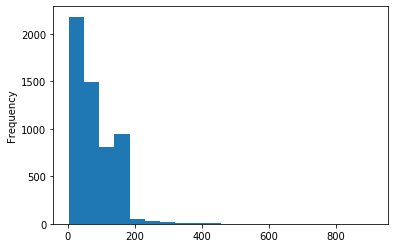

In [13]:
messages.length.plot(bins=20, kind='hist')

In [14]:
messages.length.describe()

count    5574.000000
mean       80.478292
std        59.848302
min         2.000000
25%        36.000000
50%        62.000000
75%       122.000000
max       910.000000
Name: length, dtype: float64

Find and print that really long one...

In [15]:
largest = messages['length'].idxmax()
print(messages.loc[largest]['message'])

For me the love should start with attraction.i should feel that I need her every time around me.she should be the first thing which comes in my thoughts.I would start the day and end it with her.she should be there every time I dream.love will be then when my every breath has her name.my life should happen around her.my life will be named to her.I would cry for her.will give all my happiness and take all her sorrows.I will be ready to fight with anyone for her.I will be in love when I will be doing the craziest things for her.love will be when I don't have to proove anyone that my girl is the most beautiful lady on the whole planet.I will always be singing praises for her.love will be when I start up making chicken curry and end up makiing sambar.life will be the most beautiful then.will get every morning and thank god for the day because she is with me.I would like to say a lot..will tell later..


We can see if there is there any difference in message length between spam and ham by running the following code to plot them side by side. 

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f67e4b27ac8>,
      dtype=object)

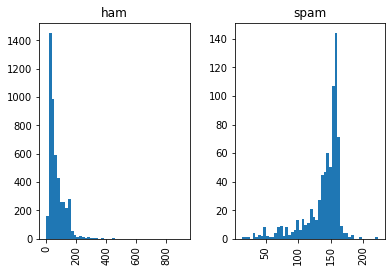

In [16]:
messages.hist(column='length', by='label', bins=50)

Great, but this is not sufficient for us to create a classifier.  We need machine learning!

## Part 2: Data preprocessing

Next we convert the raw messages (sequence of characters) into vectors (sequences of numbers).

The mapping is not 1-to-1; we'll use the [bag-of-words](http://en.wikipedia.org/wiki/Bag-of-words_model) approach, where each unique word in a text will be represented by one number.

As a first step, here is a function that will split a message into its individual words:

In [17]:
def split_into_tokens(message):
    return TextBlob(message).words

You should tokenize them by applying the split_into_tokens method to the message column of the dataframe in the following cell.  Print the results to convince yourself that they are correct.  You do not need to store these results back in the dataframe.  

In [18]:
print(messages.message.apply(split_into_tokens))


0       [Go, until, jurong, point, crazy, Available, o...
1                          [Ok, lar, Joking, wif, u, oni]
2       [Free, entry, in, 2, a, wkly, comp, to, win, F...
3       [U, dun, say, so, early, hor, U, c, already, t...
4       [Nah, I, do, n't, think, he, goes, to, usf, he...
                              ...                        
5569    [This, is, the, 2nd, time, we, have, tried, 2,...
5570         [Will, ü, b, going, to, esplanade, fr, home]
5571    [Pity, was, in, mood, for, that, So, any, othe...
5572    [The, guy, did, some, bitching, but, I, acted,...
5573                     [Rofl, Its, true, to, its, name]
Name: message, Length: 5574, dtype: object


With textblob, we can detect [part-of-speech (POS)](http://www.ling.upenn.edu/courses/Fall_2007/ling001/penn_treebank_pos.html) tags with:

In [19]:
TextBlob("Hello world, how is it going?").tags  # list of (word, POS) pairs

[('Hello', 'NNP'),
 ('world', 'NN'),
 ('how', 'WRB'),
 ('is', 'VBZ'),
 ('it', 'PRP'),
 ('going', 'VBG')]

In [20]:
def split_into_lemmas(message):
    words = TextBlob(message).words
    # for each word, take its "base form" = lemma 
    return [word.lemma for word in words]

Normalize words into their base form ([lemmas](http://en.wikipedia.org/wiki/Lemmatisation)) by applying the split_into_lemmas function below to the message column of the dataframe.  Again, you do not need to store these results, so you can use `.head()` to view the output.  

In [21]:
column = messages["message"].apply(split_into_lemmas)
column.head(10)

0    [Go, until, jurong, point, crazy, Available, o...
1                       [Ok, lar, Joking, wif, u, oni]
2    [Free, entry, in, 2, a, wkly, comp, to, win, F...
3    [U, dun, say, so, early, hor, U, c, already, t...
4    [Nah, I, do, n't, think, he, go, to, usf, he, ...
5    [FreeMsg, Hey, there, darling, it, 's, been, 3...
6    [Even, my, brother, is, not, like, to, speak, ...
7    [As, per, your, request, 'Melle, Melle, Oru, M...
8    [WINNER, As, a, valued, network, customer, you...
9    [Had, your, mobile, 11, month, or, more, U, R,...
Name: message, dtype: object

You can probably think of many more ways to improve the preprocessing: decoding HTML entities (those `&amp;` and `&lt;` we saw above); filtering out stop words (pronouns etc); adding more features, such as an word-in-all-caps indicator and so on.  So keep those in mind for later...

## Part 3: Data to vectors

Now need to convert each message, represented as a list of tokens (lemmas) above, into a vector that machine learning models can understand.

Doing that requires essentially three steps, in the bag-of-words model:

1. counting how many times does a word occur in each message (term frequency)
2. weighting the counts, so that frequent tokens get lower weight (inverse document frequency)
3. normalizing the vectors to unit length, to abstract from the original text length


Each vector has as many dimensions as there are unique words in the SMS corpus.  We can count the number of unique words using the following cell...

In [22]:
bow_transformer = CountVectorizer(analyzer=split_into_lemmas).fit(messages['message'])
print(len(bow_transformer.vocabulary_))

11012


Here we used `scikit-learn` (`sklearn`), a powerful Python library for teaching machine learning. It contains a multitude of various methods and options.

Let's take one text message and get its bag-of-words counts as a vector, putting to use our new `bow_transformer`:

In [23]:
message4 = messages['message'][3]
print(message4)

U dun say so early hor... U c already then say...


In [24]:
bow4 = bow_transformer.transform([message4])
print(bow4)
print(bow4.shape)

print(bow4.toarray())

  (0, 4191)	2
  (0, 4764)	1
  (0, 5365)	1
  (0, 6221)	1
  (0, 6245)	1
  (0, 7139)	1
  (0, 9282)	2
  (0, 9591)	1
  (0, 10056)	1
(1, 11012)
[[0 0 0 ... 0 0 0]]


So, nine unique words are in this message.  Two of them appear twice, the rest only once. 

Write some code in the next cell that identifies the words that appear twice.  You are encouraged to use the CountVectorizer's get_feature_names() method to make this easier

In [25]:
words = bow_transformer.get_feature_names()[4191], bow_transformer.get_feature_names()[9282]
print(words)

('U', 'say')


The bag-of-words counts for the entire SMS corpus are a large, sparse matrix (generated using `bow_transformer.transform()` on the appropriate dataframe column).  In the following cell, calculate the sparsity using `.nnz` and the shape.  

In [26]:
messages_bow = bow_transformer.transform(messages['message'])
tup = messages_bow.get_shape()
size = tup[0] * tup[1]
unclean_sparc_size = 1-(messages_bow.nnz/size)
print(unclean_sparc_size)

0.9986702538418799


Next, lets see what the bow array looks like if we convert it to a "dense" array and print it out.  Lots of 0s right?  

You should next calculate the storage required by both the sparse representation and the full array by using `numpy_array.data.nbytes` to find its size

In [27]:
messages_array = messages_bow.toarray()
print(messages_array)
print(messages_array.data.nbytes)


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
491047104


Term weighting and normalization can be done with [TF-IDF](http://en.wikipedia.org/wiki/Tf%E2%80%93idf), using scikit-learn's `TfidfTransformer`, and we can apply it to the message we used above.  

In [28]:
tfidf_transformer = TfidfTransformer().fit(messages_bow)
tfidf4 = tfidf_transformer.transform(bow4)
print(tfidf4)

  (0, 10056)	0.22510385070095637
  (0, 9591)	0.1955442748962185
  (0, 9282)	0.49597495370832545
  (0, 7139)	0.4269339327922034
  (0, 6245)	0.3100112284407115
  (0, 6221)	0.2913528957227454
  (0, 5365)	0.2860779240943588
  (0, 4764)	0.25892595706356525
  (0, 4191)	0.391088549792437


To transform the entire bag-of-words corpus into TF-IDF corpus at once:

In [29]:
messages_tfidf = tfidf_transformer.transform(messages_bow)
print(messages_tfidf.shape)

(5574, 11012)


## Part 4: Training a model, detecting spam

With messages represented as vectors, we can finally train our spam/ham classifier.

We'll be using scikit-learn here, choosing the [Naive Bayes](http://en.wikipedia.org/wiki/Naive_Bayes_classifier) classifier:

In [30]:
spam_detector = MultinomialNB().fit(messages_tfidf, messages['label'])

Let's try classifying our single random message:

In [31]:
print('predicted:', spam_detector.predict(tfidf4)[0])
print('expected:', messages.label[3])

predicted: ham
expected: ham


Hooray!

A natural question is to ask, how many messages do we classify correctly overall?  The following cell will calculate this for us...

In [32]:
all_predictions = spam_detector.predict(messages_tfidf)
print('accuracy', accuracy_score(messages['label'], all_predictions))

accuracy 0.9721923214926445


There are quite a few possible metrics for evaluating model performance. Which one is the most suitable depends on the task. For example, the cost of mispredicting "spam" as "ham" is probably much lower than mispredicting "ham" as "spam".  Differences between errors can be illuminated using metrics other than accuracy, so in the following cell, and in the cells below, you should use sklearn to calculate recall and precision in addition to accuracy.  Please include statements about what you can interpret from these results

In [33]:
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
precision = precision_score(messages['label'], all_predictions, pos_label = "ham")
recall = recall_score(messages['label'], all_predictions, pos_label = "ham")
accuracy = accuracy_score(messages['label'], all_predictions)

print("Precision:", precision)
print("Recall:", recall)
print("Accuracy:", accuracy)

Precision: 0.9688879967884384
Recall: 1.0
Accuracy: 0.9721923214926445


When labeling 'ham' messages as the positive label, one can see that each of our results is relatively high. To start, our accuracy is at 97%. This means that only 3% of the messages were incorrectly predicted, whether that was a false postive or negative. When looking at our precision and recall, one can see that the percision is lower than the recall. This means that our model incorrectly marked more false postives (more spam got into our inbox) than false negatives (ham sent to spam folder). Beyond that, but our recall was 100%, so no ham messages were sent to the spam folder. Thinking about a real world scenario for this program, these results are favored compared to their inverse because it would be worse to miss an important message than to see an unimportant one.

## Part 5: Let's get realistic

In the above "evaluation", we committed a cardinal sin. For simplicity of demonstration, we evaluated accuracy on the same data we used for training. **Never evaluate on the same dataset you train on!**

Such evaluation tells us nothing about the true predictive power of our model. If we simply remembered each example during training, the accuracy on training data would trivially be 100%, even though we wouldn't be able to classify any new messages.  This is exactly like memorizing the exact answers for an exam without understanding the underlying material!

A proper way is to split the data into a training/test set, where the model only ever sees the **training data** during its model fitting and parameter tuning. The **test data** is never used in any way -- thanks to this process, we make sure we are not "cheating", and that our final evaluation on test data is representative of true predictive performance.

The following code splits the dataset into a training and testing set.  

In [34]:
msg_train, msg_test, label_train, label_test = \
    train_test_split(messages['message'], messages['label'], test_size=0.2)

print(len(msg_train), len(msg_test), len(msg_train) + len(msg_test))

4459 1115 5574


So, as requested, the test size is 20% of the entire dataset.

Next, lets set up our split datasets to be ready to be used by the Bayes model for training and prediction...

In [35]:
train_messages_bow = bow_transformer.transform(msg_train)
train_tfidf_transformer = TfidfTransformer().fit(train_messages_bow)
train_messages_tfidf = train_tfidf_transformer.transform(train_messages_bow)
test_messages_bow = bow_transformer.transform(msg_test)
test_tfidf_transformer = TfidfTransformer().fit(test_messages_bow)
test_messages_tfidf = test_tfidf_transformer.transform(test_messages_bow)

We can train a new Naive Bayes classifier with only the training data, and test it with the test data, and our accuracy should drop.  In this cell answer: why?  

In [36]:
split_spam_detector = MultinomialNB().fit(train_messages_tfidf, label_train)
test_predictions = split_spam_detector.predict(test_messages_tfidf)
precision = precision_score(messages['label'], all_predictions, pos_label = "ham")
recall = recall_score(messages['label'], all_predictions, pos_label = "ham")
accuracy = accuracy_score(messages['label'], all_predictions)

unclean_p = precision
unclean_r = recall
unclean_a = accuracy

print("Updated Precision:", precision)
print("Updated Recall:", recall)
print("Updated Accuracy:", accuracy)

Updated Precision: 0.9688879967884384
Updated Recall: 1.0
Updated Accuracy: 0.9721923214926445


Our accuracy dropped because we are showing the model messages that it has never seen before. The prevous accuracy was tested on data the model had already trained on, thus it will natrually be better at predicting that data correctly.

Next, re-run this experiment changing the test size to a different value (in the subsequent cells of this part) and develop an explanation for the results (it should be different than your accuracy value)

By changing the testing set size to 50%, the model accuracy value decreased by roughly 2%. This is expected because lowering the training data means that the model has less information to base its preditions off of. Additionally, the data that was taken away from the training data was put into the testing data, which tests the model against more edge cases that "trip up" the model into making false predictions.

## Part 6: Next Steps

In the following cells you should make some changes to the dataset (cast to lowercase, remove numbers, remove non-words, add content, etc) to sufficiently change the sparsity percentage.  The number of columns in your bag of words model should be significantly smaller.  The goal of this is see the size comparison in the non-compressed version of the matrix (`toarray`) vs the sparse representation as the size of the data changes.  If we didn't have a sparse representation, our ability to use a BOW model would be very limiting...

Run the experiments again to assess the accuracy of your new dataset and compare it with your previous results.  You should make arguments about what caused the changes and why they make sense.  Calculate and compare the storage requirements of the non-sparse and sparse representations, and argue how using sparse matricies can enable better accuracy.  

___This HUGE block of code is just all the previous prep and training but applied to the cleaned column.___

In [37]:
#make model for the cleaned stuff
messages.clean_message.apply(split_into_tokens)
column = messages["clean_message"].apply(split_into_lemmas)
bow_transformer = CountVectorizer(analyzer=split_into_lemmas).fit(messages['clean_message'])
message4 = messages['clean_message'][3]
bow4 = bow_transformer.transform([message4])
messages_bow = bow_transformer.transform(messages['clean_message'])
tup = messages_bow.get_shape()
size = tup[0] * tup[1]
tfidf_transformer = TfidfTransformer().fit(messages_bow)
tfidf4 = tfidf_transformer.transform(bow4)
messages_tfidf = tfidf_transformer.transform(messages_bow)
spam_detector = MultinomialNB().fit(messages_tfidf, messages['label'])
all_predictions = spam_detector.predict(messages_tfidf)
msg_train, msg_test, label_train, label_test = \
train_test_split(messages['clean_message'], messages['label'], test_size=0.2)
train_messages_bow = bow_transformer.transform(msg_train)
train_tfidf_transformer = TfidfTransformer().fit(train_messages_bow)
train_messages_tfidf = train_tfidf_transformer.transform(train_messages_bow)
test_messages_bow = bow_transformer.transform(msg_test)
test_tfidf_transformer = TfidfTransformer().fit(test_messages_bow)
test_messages_tfidf = test_tfidf_transformer.transform(test_messages_bow)
split_spam_detector = MultinomialNB().fit(train_messages_tfidf, label_train)
test_predictions = split_spam_detector.predict(test_messages_tfidf)
precision = precision_score(messages['label'], all_predictions, pos_label = "ham")
recall = recall_score(messages['label'], all_predictions, pos_label = "ham")
accuracy = accuracy_score(messages['label'], all_predictions)
messages_bow = bow_transformer.transform(messages['clean_message'])
tup = messages_bow.get_shape()
size = tup[0] * tup[1]
clean_sparc_size = 1-(messages_bow.nnz/size)


#Print old results
print("unclean Precision:",unclean_p)
print("unclean Recall:",unclean_r)
print("unclean Accuracy:",unclean_a)
print("")

#Print new results
print("cleaned Precision:", precision)
print("cleaned Recall:", recall)
print("cleaned Accuracy:", accuracy)

print("_____________________________")

#print old sparcity size
print("unclean sparcity size:", unclean_sparc_size)
print("")

#print new sparcity size
print("Clean sparcity size:", clean_sparc_size)

unclean Precision: 0.9688879967884384
unclean Recall: 1.0
unclean Accuracy: 0.9721923214926445

cleaned Precision: 0.9652069586082783
cleaned Recall: 1.0
cleaned Accuracy: 0.9687836383207751
_____________________________
unclean sparcity size: 0.9986702538418799

Clean sparcity size: 0.9981111760857069


In an attempt to change the sparcity percentage, the data has been cleaned for punctuation, capital letters, special characters, and spelling. The first observation I would like to describe is the accuracy. Before the cleaning was performed, the model accuracy (with a test size of 0.2) was 0.972. After the cleaning was performed, the accuracy dropped to 0.968. This decrease can be explained by further inspecting the bag of words for each approach. 

The bag of words for the uncleaned data had 11012 unique words, while the cleaning data only had 7225 unique words. By removing these characteritics, the model had less information to base its predictions off of. Additionally, some of these removed characteristics were key features of a spam message (I.E. all caps, lots of !!!!!!!, Etc.). 

Looking at the percision and recall, you can see the recall was 100% for both, however the precision dropped by about .3%. This value is coupled with accuracy, so it makes sense that this value lowered with accuracy.

Finally, looking at the size of the sparcity matrix, you can see that it lowered by 0.007%. This value is negligable, but can be explained by removing more unique characters.